# Generative Adversarial Networks

<img src="GAN.JPG">

## Download MNIST and load it

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import shutil

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from keras.datasets import cifar10
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_data = train_data / 255.
test_data = test_data / 255.

def img_tile(imgs, aspect_ratio=1.0, tile_shape=None, border=1,
             border_color=0):
    ''' Tile images in a grid.
    If tile_shape is provided only as many images as specified in tile_shape
    will be included in the output.
    '''

    imgs = np.array(imgs)
    if imgs.ndim != 3 and imgs.ndim != 4:
        raise ValueError('imgs has wrong number of dimensions.')
    n_imgs = imgs.shape[0]

    # Grid shape
    img_shape = np.array(imgs.shape[1:])
    if tile_shape is None:
        img_aspect_ratio = img_shape[1] / float(img_shape[0])
        aspect_ratio *= img_aspect_ratio
        tile_height = int(np.ceil(np.sqrt(n_imgs * aspect_ratio)))
        tile_width = int(np.ceil(np.sqrt(n_imgs / aspect_ratio)))
        grid_shape = np.array((tile_height, tile_width))
    else:
        assert len(tile_shape) == 2
        grid_shape = np.array(tile_shape)

    # Tile image shape
    tile_img_shape = np.array(imgs.shape[1:])
    tile_img_shape[:2] = (img_shape[:2] + border) * grid_shape[:2] - border

    # Assemble tile image
    tile_img = np.empty(tile_img_shape)
    tile_img[:] = border_color
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            img_idx = j + i * grid_shape[1]
            if img_idx >= n_imgs:
                # No more images - stop filling out the grid.
                break
            img = imgs[img_idx]
            yoff = (img_shape[0] + border) * i
            xoff = (img_shape[1] + border) * j
            tile_img[yoff:yoff + img_shape[0], xoff:xoff + img_shape[1], ...] = img

    return tile_img

Using TensorFlow backend.


170500096/170498071 [==============================] - 1174s 7us/step


## show MNIST

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


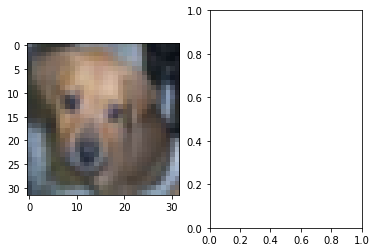

In [3]:
# show data
idx = np.random.randint(0, train_data.shape[0])
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[idx]
ax1.imshow(sample_data);
# ax2.hist(sample_data, bins=20, range=[0, 1]);

## Delete summary folder and make it

In [ ]:
SUMMARY_DIR = './gan_summary'
TRAIN_DIR = SUMMARY_DIR + '/train'
TEST_DIR = SUMMARY_DIR + '/test'
IMAGE_DIR = SUMMARY_DIR + '/image'

if os.path.exists(SUMMARY_DIR):
    shutil.rmtree(SUMMARY_DIR)
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)
    os.makedirs(TRAIN_DIR)
    os.makedirs(TEST_DIR)
    os.makedirs(IMAGE_DIR)

## Define tensorflow graph

In [ ]:
def fully_connected(inputs, out_channel, name='fc'):
    """
    very simple fully connected layer function

    Args:
        inputs: a batch of input tensor [batch_size, n]
                where n is the number of input feature dimension
        out_channel: output channel dimension

    Returns:
        fc: inputs * weights + biases [batch_size, out_channel]
    """
    # in_channel: input channel dimension
    # w_shape: shape of weight matrix
    # b_shape: shape of bias vector
    in_channel = inputs.get_shape().as_list()[1]
    w_shape = [in_channel, out_channel]
    b_shape = [out_channel]

    # Define weight matrix variable, bias vector variable
    with tf.variable_scope(name):
        # To share the variables you have to use
        # a function 'tf.get_variable' instead of 'tf.Variable'
        weights = tf.get_variable('weights', shape=w_shape,
                                  initializer=tf.truncated_normal_initializer(stddev=0.02))
        biases = tf.get_variable('biases', shape=b_shape,
                                 initializer=tf.constant_initializer(0.0))

        fc = tf.matmul(inputs, weights)
        fc = tf.nn.bias_add(fc, biases)

        return fc

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
              initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

        return conv

def bn(x, is_training, scope, axis=-1):
    return tf.layers.batch_normalization(x, epsilon = 1e-5, momentum = 0.9, training = is_training, name = scope, axis=axis) # add axis=1

def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
        initializer=tf.constant_initializer(bias_start))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, name="deconv2d", stddev=0.02, with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))

        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])

        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape, strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)
        
def discriminator(x, reuse=None, is_training=True):
    """
    build the discriminator

    Args:
        x: a batch of input to the network [batch_size, 32, 32, 3]

    returns:
        net: output of the discriminator [batch_size, 1]
    """
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

#             if self.dataset_name == 'cifar10':
        if True:
            print("D:",x.get_shape()) # 32, 32, 3 = 3072
            net = lrelu(conv2d(x, 64, 5, 5, 2, 2, name='d_conv1'))
            print("D:",net.get_shape())
            net = lrelu(bn(conv2d(net, 128, 5, 5, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
            print("D:",net.get_shape())
            net = lrelu(bn(conv2d(net, 256, 5, 5, 2, 2, name='d_conv3'), is_training=is_training, scope='d_bn3'))
            print("D:",net.get_shape())
            net = lrelu(bn(conv2d(net, 512, 5, 5, 2, 2, name='d_conv4'), is_training=is_training, scope='d_bn4'))
            print("D:",net.get_shape())
            net = tf.reshape(net, [batch_size, -1])
            print("D:",net.get_shape())
            out_logit = linear(net, 1, scope='d_fc5')
            print("D:",net.get_shape())
            out = tf.nn.sigmoid(out_logit)
            print("D:",out.get_shape())
            print("------------------------")

        else: # mnist / fashion mnist
            #print(x.get_shape())
            net = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
            net = lrelu(bn(conv2d(net, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
            net = tf.reshape(net, [batch_size, -1])
            net = lrelu(bn(linear(net, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn3'))
            out_logit = linear(net, 1, scope='d_fc4')
            out = tf.nn.sigmoid(out_logit)

        return out

def generator(z, is_training=True):
    """
    build the generator

    Args:
        z: a batch of input to the network [batch_size, z_dim]

    Returns:
        net: output of the generator [batch_size, 28, 28, 1]
    """
    with tf.variable_scope('generator') as scope:

        h_size = 32
        h_size_2 = 16
        h_size_4 = 8
        h_size_8 = 4
        h_size_16 = 2

        print("G:",z.get_shape())
        net = linear(z, 512*h_size_16*h_size_16, scope='g_fc1')
        print("G:",net.get_shape())
        net = tf.nn.relu(
            bn(tf.reshape(net, [batch_size, h_size_16, h_size_16, 512]),is_training=is_training, scope='g_bn1')
            )
        print("G:",net.get_shape())
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, h_size_8, h_size_8, 256], 5, 5, 2, 2, name='g_dc2'),is_training=is_training, scope='g_bn2')
            )
        print("G:",net.get_shape())
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, h_size_4, h_size_4, 128], 5, 5, 2, 2, name='g_dc3'),is_training=is_training, scope='g_bn3')
            )
        print("G:",net.get_shape())
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, h_size_2, h_size_2, 64], 5, 5, 2, 2, name='g_dc4'),is_training=is_training, scope='g_bn4')
            )
        print("G:",net.get_shape())
        out = tf.nn.sigmoid(
            deconv2d(net, [batch_size, 32, 32, 3], 5, 5, 2, 2, name='g_dc5')
            )
        print("G:",out.get_shape())
        print("------------------------")
    return out

def get_loss(D_real, D_fake, eps=1e-10):
    """
    get loss of GAN

    Args:
        D_real: Real Discriminator output [batch_size, 1]
        D_fake: Fake discriminator output [batch_size, 1]

    Returns:
        D_loss: Discriminator loss
        G_loss: Generator loss
    """
    D_loss = -(tf.reduce_mean(tf.log(D_real+eps)) + tf.reduce_mean(tf.log(1-D_fake+eps)))
    G_loss = -tf.reduce_mean(tf.log(D_fake+eps))

    return D_loss, G_loss


def get_next_batch(data, label, batch_size):
    """
    get 'batch_size' amount of data and label randomly

    Args:
        data: data
        label: label
        batch_size: # of data to get

    Returns:
        batch_data: data of 'batch_size'
        batch_label: coresponding label of batch_data
    """
    n_data = data.shape[0]
    random_idx = random.sample(range(1, n_data), batch_size)

    batch_data = data[random_idx]
    batch_label = label[random_idx]
    return batch_data, batch_label


# Set hyperparameters
batch_size = 100
z_dim = 128
max_step = 20000
lrD = 1e-3
lrG = 1e-4
beta1 = 0.5

############################# Build the model #############################
# Define image tensor x placeholder
x = __________________________________________________
# Define z vector as uniform distribution between [-1, 1]
z = __________________________________________________

# Build discriminator where input data is real image x
______________________________________________________
# Build generator
______________________________________________________
# Build discriminator where input data is generated image G
______________________________________________________

# Get D_loss and G_loss
______________________________________________________

# Make optimization op
______________________________________________________
______________________________________________________

# To update the generator and the discriminator
# get their network parameters
______________________________________________________
______________________________________________________

# Make train op for each network
D_train = ____________________________________________
G_train = ____________________________________________

# Make initialization op
init = tf.global_variables_initializer()


## Train GAN

In [ ]:
with tf.Session() as sess:
    # Define writer
    train_writer = tf.summary.FileWriter(TRAIN_DIR, sess.graph)
    test_writer = tf.summary.FileWriter(TEST_DIR)

    # Initialize variables
    sess.run(init)
    
    # Before train the model, shows train data and save it
    batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
    train_tiled = img_tile(batch_x, border_color=1.0)
    train_tiled = np.squeeze(train_tiled)
    print("Training data")
    plt.imshow(train_tiled)
    plt.show()
    plt.imsave(IMAGE_DIR + '/train.png', train_tiled)
    
    samples = []
    for step in range(max_step):
        batch_x, batch_y = get_next_batch(train_data, train_label, batch_size)
        
        _, d_loss = sess.run([D_train, D_loss], feed_dict={x: batch_x})
        _, g_loss = sess.run([G_train, G_loss])
        #summary = sess.run(merged, feed_dict={x: batch_x})
        #train_writer.add_summary(summary, step)
        
        # Save generarted data to make gif files
        if step % 50 == 0:
            g = sess.run(G)
            g_tiled = img_tile(g, border_color=1.0)
            g_tiled = np.squeeze(g_tiled)
            samples.append(g_tiled)
        if step % 200 == 0:
            print("{} steps |  G_loss: {:.4f}, D_loss: {:.4f}".format(step, g_loss, d_loss))
            plt.imshow(g_tiled)
            plt.show()
            plt.imsave(IMAGE_DIR + '/{}.png'.format(str(step).zfill(6)),
                       g_tiled)
#             plt.close()

In [ ]:
import imageio
imageio.mimsave(SUMMARY_DIR + '/generated.gif', samples)

# Reference
https://github.com/4thgen/DCGAN-CIFAR10